# Start with adversarial images in a simple linear classifier
Following http://karpathy.github.io/2015/03/30/breaking-convnets/

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def linear(input, output_dim, scope=None):
    norm = tf.random_normal_initializer()
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b
    
def conv_relu(input, kernel_shape, bias_shape, scope=None):
    with tf.variable_scope(scope or 'conv_relu'):
        w = tf.get_variable("w", kernel_shape, initializer=tf.random_normal_initializer())
        b = tf.get_variable("b", bias_shape, initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding='SAME')
        return tf.nn.relu(conv + b)

def max_pool_2x2(x, scope=None):
    with tf.variable_scope(scope or 'max_pool_2x2'):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Create a model with 784 inputs connecting directly to 10 softmax outputs

In [3]:
class Linear(object):
    def __init__(self, num_steps, batch_size, log_every):
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.log_every = log_every
        self.hidden_size = 100
        
        self._create_model()
        
    def _create_model(self):
        with tf.variable_scope('Linear'):
            self.x = tf.placeholder(tf.float32, shape=(None, 784))
            self.t = tf.placeholder(tf.float32, shape=(None, 10))
            self.y = linear(self.x, 10)
            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y, labels=self.t))
            self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
            correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.t,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def train(self):
        with tf.Session() as session:
            tf.global_variables_initializer().run()
            
            for i in range(self.num_steps):
                batch = mnist.train.next_batch(self.batch_size)
                if i%100 == 0:
                    train_accuracy = session.run(self.accuracy, feed_dict={self.x:batch[0], self.t: batch[1]})
                    print("step %d, training accuracy %g"%(i, train_accuracy))
                session.run([self.cross_entropy,self.optimizer], feed_dict={self.x: batch[0], self.t: batch[1]})
            saver = tf.train.Saver()
            save_path = saver.save(session, "/resources/data/Linear.weights")
            print("Model saved in file: %s" % save_path)
            print("test accuracy %g"%session.run(self.accuracy, feed_dict={self.x:mnist.test.images, self.t: mnist.test.labels}))

In [4]:
model = Linear(30000,100,100)
model.train()

step 0, training accuracy 0.07
step 100, training accuracy 0.11
step 200, training accuracy 0.07
step 300, training accuracy 0.06
step 400, training accuracy 0.08
step 500, training accuracy 0.08
step 600, training accuracy 0.09
step 700, training accuracy 0.09
step 800, training accuracy 0.12
step 900, training accuracy 0.06
step 1000, training accuracy 0.14
step 1100, training accuracy 0.1
step 1200, training accuracy 0.14
step 1300, training accuracy 0.1
step 1400, training accuracy 0.12
step 1500, training accuracy 0.14
step 1600, training accuracy 0.2
step 1700, training accuracy 0.16
step 1800, training accuracy 0.24
step 1900, training accuracy 0.2
step 2000, training accuracy 0.24
step 2100, training accuracy 0.22
step 2200, training accuracy 0.26
step 2300, training accuracy 0.27
step 2400, training accuracy 0.22
step 2500, training accuracy 0.27
step 2600, training accuracy 0.3
step 2700, training accuracy 0.26
step 2800, training accuracy 0.22
step 2900, training accuracy 0.

Pick 10 images correctly classified as 2. 
Add 5% weights of class 6 to the images. 
Images classified as 6. 

In [5]:
twos = mnist.test.images[mnist.test.labels[:,2]==1]
with tf.Session() as session:
    saver = tf.train.Saver()
    save_path = saver.restore(session, "/resources/data/Linear.weights")
    w = session.run(tf.trainable_variables()[0])
    b = session.run(tf.trainable_variables()[1])
    twos = twos[np.argmax(session.run(model.y, feed_dict={model.x:twos}),axis=1)==2][:10]
    twos_manip = twos+0.05*w[:,6]
    print(np.argmax(session.run(model.y, feed_dict={model.x:twos}),axis=1))
    print(np.argmax(session.run(model.y, feed_dict={model.x:twos_manip}),axis=1))


[2 2 2 2 2 2 2 2 2 2]
[6 6 6 6 6 6 6 6 6 6]


Looking at the images, the first row are the originals, the second row are the adversarial images after manipulation

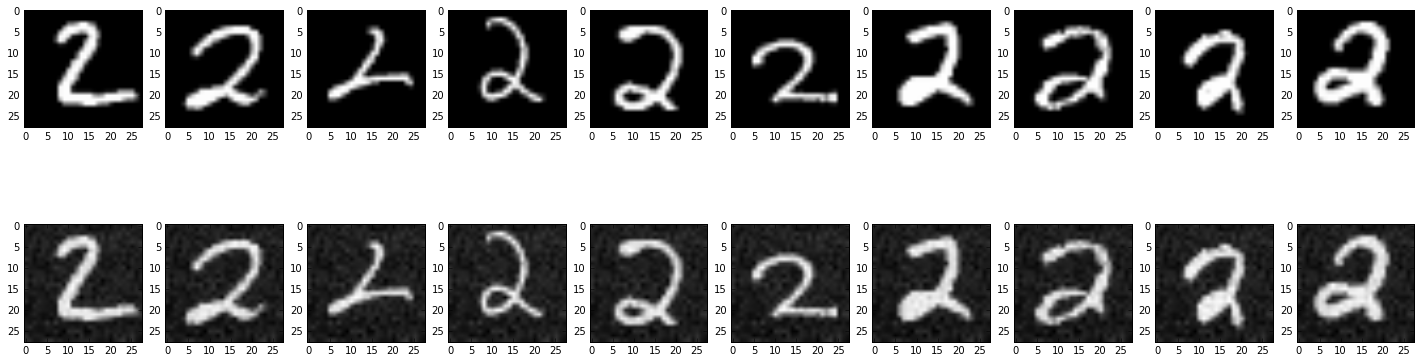

In [6]:
fig, axes = plt.subplots(figsize=(20, 6))
fig.tight_layout()
for i,img in enumerate(twos):
    ax = plt.subplot(2,10,i+1)
    plt.imshow(img.reshape(28,28),cmap='gray')
for i,img in enumerate(twos_manip):
    ax = plt.subplot(2,10,i+11)
    plt.imshow(img.reshape(28,28),cmap='gray')

The difference between each pair of examples are the same in this simple case

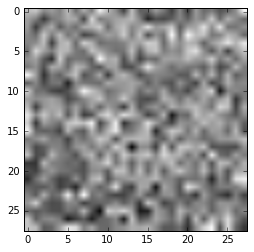

In [7]:
plt.imshow(w[:,6].reshape(28,28),cmap='gray')